# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [616]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

import math

## Helper Functions

In [617]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    #return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=8):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

"""
# Extra parameter added to this function
# quad: our region of interest is a quadrilateral
"""
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, quad):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    """
    merge_lines takes all the lines returned by HoughLinesP and returns left and right lane lines
    """
    lines = merge_lines(lines, quad)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, alpha=0.8, beta=1., gamma=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, alpha, img, beta, gamma)

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [618]:
"""
Merge multiple lines
Steps
1) Go through each line and extract its side (left, right), slope, intercept and length
2) Get average of left and right lines
3) Get a moving average of the proposed and past left and right lines
4) Return the final left and right lines to be painted
"""
def merge_lines(lines, quad):
    rslopes = []
    ricpts = []
    rlengths = []
    lslopes = []
    licpts = []
    llengths = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            m = (y2-y1)/(x2-x1)
            length = distance(x1,y1,x2,y2)
            if (abs(m) < 0.3) or (abs(m)>10):
                continue
            if (m>0):
                icpt = y2-m*x2
                rslopes.append(m)
                ricpts.append(icpt)
                rlengths.append(length)
            else:
                icpt = y1-m*x1
                lslopes.append(m)
                licpts.append(icpt)
                llengths.append(length)
    lline = get_avg_line(lslopes, licpts, llengths, quad)
    rline = get_avg_line(rslopes, ricpts, rlengths, quad)
    lines = moving_average(lline, rline)
    return lines


"""
Computes the distance between 2 points
"""
def distance(x1, y1, x2, y2):
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)

"""
Returns average of multiple lines. Multiple lines are represented by
slopes, icpts and lengths of those lines.
average line returned will be within the quad provided
"""
def get_avg_line(slopes, icpts, lengths, quad):
    if (len(slopes) == 0 or len(icpts) == 0):
        return np.array([np.array([0, 0, 0, 0])])
    
    """
    Take a weighted average of all lines provided for getting the final line.
    Weights are the lengths of individual lines.
    Rationale - a longer line should have a larger weight.
    We can refine this logic, e.g., by:
    - removing the outliers within these lines
    - merge lines closer to each other first (slope and mid-points)
    - try out different weighing schemes
    """
    slope = np.average(slopes, axis=None, weights=lengths)
    icpt = np.average(icpts, axis=None, weights=lengths)
    
    """
    Constrain the average line to be within the region of interest
    """
    y1 = quad[1][1]
    y2 = quad[0][1]
    x1 = int((y1-icpt)/slope)
    x2 = int((y2-icpt)/slope)
    line = np.array([np.array([x1,y1,x2,y2])])
    return line

"""
Returns a weighted moving average of currently computed left/right lines and past left/right lines.
numpy's vector methods were somewhat useful.
Possible improvements here
- We can adapt # of historical data-points to consider and how to weigh them
"""
def moving_average(lline, rline):
    global history
    N_MOVING_AVERAGE = 20
    if (len(history) != 0):        
        N = N_MOVING_AVERAGE if (len(history)>N_MOVING_AVERAGE-1) else len(history)
        lsum = lline*N
        rsum = rline*N
        """ Go back N data-points in history. """
        for i in range(1,N):
            [l,r] = history[0-i]
            """ Linearly decreasing weights for distant history """
            lsum = lsum + (N-i)*l
            rsum = rsum + (N-i)*r
        lline = 2*lsum/(N*N+N)
        lline = lline.astype(int)
        rline = 2*rsum/(N*N+N)
        rline = rline.astype(int)
    history.append([lline, rline])
    return [lline, rline]

"""
Figure out a quadrilateral pegged to the bottom of the frame. Triangle chopped from the top.
Possible improvement here:
- Region of interest should be adpated based on speed, up/down grade of the road, angle of the camera mount etc.
"""
def get_quad(shape):
    top_x_chopoff = int(.1*shape[1])
    top_y_chopoff = int(.1*shape[0])
    bottom_y_chopoff = 0
    bottom_x_chopoff = int(.1*shape[1])

    left_bottom = [bottom_x_chopoff, shape[0]-bottom_y_chopoff]
    left_top = [int(shape[1]/2-top_x_chopoff), int(shape[0]/2+top_y_chopoff)]
    right_top = [int(shape[1]/2+top_x_chopoff), int(shape[0]/2+top_y_chopoff)]
    right_bottom = [shape[1]-bottom_x_chopoff, shape[0]-bottom_y_chopoff]
    quad = [left_bottom, left_top, right_top, right_bottom] 
    return quad

"""
For debugging purposes
"""
def show_image(img, OVERRIDE=False):
    DEBUG = False | OVERRIDE
    if (DEBUG):
        plt.figure()
        plt.imshow(img)

"""
Pipeline:
a) Get grayscale, blur and get edges from canny
b) Extract edges in region of interest
c) Use Hough transform to get the merged line image
d) Draw composite image
"""
def processframe(img):
    show_image(img)
    gray = grayscale(img)
    blur_gray = gaussian_blur(gray, 3)
    edges = canny(blur_gray, 50, 150)
    show_image(edges) # Was used for debugging

    quad = get_quad(img.shape)
    region_int = np.array(quad, np.int64)
    masked_edges = region_of_interest(edges, [region_int])
    show_image(masked_edges)  # Was used for debugging

    rho = 2
    min_line_len = 15
    max_line_gap = 5
    threshold = 15
    frame = hough_lines(masked_edges, rho, np.pi/180, threshold, min_line_len, max_line_gap, quad)
    final_img = weighted_img(frame, img)
    return final_img

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = processframe(image)
    return result

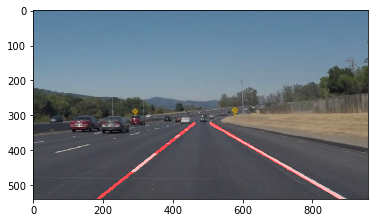

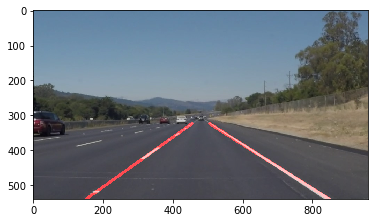

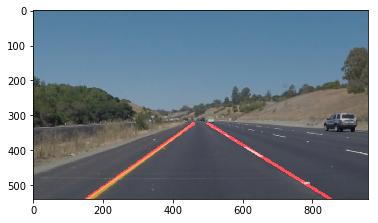

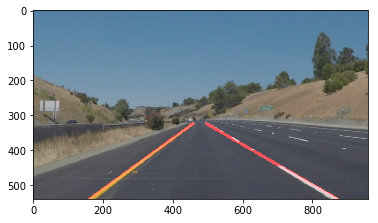

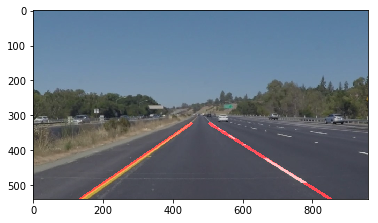

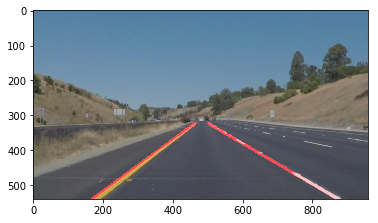

In [619]:
jpgs = os.listdir("test_images/")
for jpg in jpgs:
    jpg = "test_images/" + jpg
    show_image(jpg)
    img = mpimg.imread(jpg)
    history = []
    frame = processframe(img)
    show_image(frame, True)


# Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

Let's try the one with the solid white lane on the right first ...

In [620]:
history = []
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4



100%|█████████▉| 221/222 [00:03<00:00, 67.16it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 2.53 s, sys: 967 ms, total: 3.5 s
Wall time: 3.72 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [621]:
history = []
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4



100%|█████████▉| 681/682 [00:09<00:00, 70.76it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 7.92 s, sys: 1.89 s, total: 9.81 s
Wall time: 10 s


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [622]:
history = []
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4



100%|██████████| 251/251 [00:07<00:00, 35.58it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 5.5 s, sys: 1.3 s, total: 6.8 s
Wall time: 7.88 s


## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.
